In [1]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [2]:
import tensorflow as tf

print(tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

2.7.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [4]:
def build_generator(latent_dim=latent_dim):

    model = keras.Sequential([
  
        layers.Dense(7*7*128, activation='relu', input_dim=latent_dim),
        layers.Reshape((7,7,128)),
        layers.UpSampling2D(),

        layers.Conv2D(128, kernel_size=3, padding='same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D(),

        layers.Conv2D(64, kernel_size=3, padding='same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(channels, kernel_size=3, padding='same'),
        layers.Activation('tanh')
    ], name='generator')

    model.summary()


    return model

In [5]:
test_generator = build_generator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0 

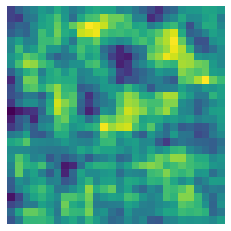

In [6]:
random_vector = tf.random.normal(shape=(1, latent_dim))
img = test_generator(random_vector, training=False)

plt.imshow(img.numpy().reshape((28, 28, 1)))
plt.axis('off')
plt.show()

In [7]:
def build_discriminator(image_shape=img_shape):

    model = keras.Sequential([
        
        layers.Conv2D(32, kernel_size=3, strides=2, padding='same', 
        input_shape=image_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),

        layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
        layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
        # layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        # layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),

        layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
        # layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
                
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
        
        ], name='discriminator')

    model.summary()
    return model

In [8]:
test_discriminator = build_discriminator()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                     

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                     

In [10]:
generator = build_generator()
# functional API
z = keras.Input(shape=latent_dim)
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)

combined_model = keras.Model(inputs=z, outputs=valid)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer
)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0 

In [11]:
def train(epochs, batch_size=128, save_interval=50):

    D_LOSS = []
    G_LOSS = []

    (X_train, _), (_, _) = keras.datasets.mnist.load_data()

    X_train = (X_train / 127.5) - 1
    X_train = np.expand_dims(X_train, axis=3)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], size=batch_size)
        imgs = X_train[idx]

        noise = tf.random.normal(shape=(batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(x=imgs, y=valid)
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs,  y=fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        noise = tf.random.normal(shape=(batch_size, latent_dim))
        g_loss = combined_model.train_on_batch(x=noise, y=valid)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
            (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)
            D_LOSS.append(d_loss)
            G_LOSS.append(g_loss)
    
    return D_LOSS, G_LOSS

In [12]:
def save_imgs(epoch):
    
    r, c = 5, 5
    noise = tf.random.normal(shape=(r*c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [13]:
epochs = 4000
batch_size = 32
save_interval = 50

D_LOSS, G_LOSS = train(epochs=epochs, batch_size=batch_size)

0 [D loss: 0.690551, acc.: 35.94%] [G loss: 0.670979]
50 [D loss: 0.698533, acc.: 46.88%] [G loss: 0.666618]
100 [D loss: 0.699107, acc.: 42.19%] [G loss: 0.684415]
150 [D loss: 0.692472, acc.: 50.00%] [G loss: 0.687269]
200 [D loss: 0.695986, acc.: 42.19%] [G loss: 0.696301]
250 [D loss: 0.696502, acc.: 43.75%] [G loss: 0.688811]
300 [D loss: 0.695097, acc.: 40.62%] [G loss: 0.691781]
350 [D loss: 0.691019, acc.: 48.44%] [G loss: 0.708459]
400 [D loss: 0.685795, acc.: 56.25%] [G loss: 0.690564]
450 [D loss: 0.694398, acc.: 53.12%] [G loss: 0.696409]
500 [D loss: 0.687193, acc.: 57.81%] [G loss: 0.663479]
550 [D loss: 0.679872, acc.: 64.06%] [G loss: 0.695600]
600 [D loss: 0.687488, acc.: 56.25%] [G loss: 0.705671]
650 [D loss: 0.694940, acc.: 48.44%] [G loss: 0.704013]
700 [D loss: 0.690948, acc.: 57.81%] [G loss: 0.700387]
750 [D loss: 0.690429, acc.: 46.88%] [G loss: 0.690693]
800 [D loss: 0.693979, acc.: 56.25%] [G loss: 0.695165]
850 [D loss: 0.701924, acc.: 45.31%] [G loss: 0.706